# RecB dissociation rates in ΔrecA and RecB1080

In [1]:
from pyberries.data import DatasetPool, Fit, get_histogram
import seaborn.objects as so
from seaborn import plotting_context
import pandas as pd

data = (DatasetPool(path='/media/daniel/HDD Daniel/DanielThedie/BACMMAN/Timelapse',
                    dsList=['230725_1', '230725_2', '230126_DT23', '230719_1', '230719_2', '240424_1', '240612_1', '240620_1',
                            '230201_DT22', '230919_1', '240424_3', '240612_3',
                            '230920_2', '240606_1', '240606_3',
                            '230118_DT23', '230720_1', '230720_2', '230726_cipro30', '230824_1', '230829_1', '230201_DT23', '230504_2sec', '230718_2sec', '240424_2', '240612_2', '240620_2',
                            '221222_cipro30ngmL', '230802_DT22', '230808_DT22', '230914_1', '240424_4', '240612_4',
                            '230802_DT21', '230913_2', '230914_2', '240606_2'],
                    groups=['WT, 0 ng/ml', 'WT, 0 ng/ml', 'WT, 0 ng/ml', 'WT, 0 ng/ml', 'WT, 0 ng/ml', 'WT, 0 ng/ml', 'WT, 0 ng/ml', 'WT, 0 ng/ml',
                            'Δ$recA$, 0 ng/ml', 'Δ$recA$, 0 ng/ml', 'Δ$recA$, 0 ng/ml', 'Δ$recA$, 0 ng/ml',
                            '$recB_{1080}$, 0 ng/ml', '$recB_{1080}$, 0 ng/ml', '$recB_{1080}$, 0 ng/ml',
                            'WT, 30 ng/ml', 'WT, 30 ng/ml', 'WT, 30 ng/ml', 'WT, 30 ng/ml', 'WT, 30 ng/ml', 'WT, 30 ng/ml', 'WT, 30 ng/ml', 'WT, 30 ng/ml', 'WT, 30 ng/ml', 'WT, 30 ng/ml', 'WT, 30 ng/ml', 'WT, 30 ng/ml',
                            'Δ$recA$, 30 ng/ml', 'Δ$recA$, 30 ng/ml', 'Δ$recA$, 30 ng/ml', 'Δ$recA$, 30 ng/ml', 'Δ$recA$, 30 ng/ml', 'Δ$recA$, 30 ng/ml',
                            '$recB_{1080}$, 30 ng/ml', '$recB_{1080}$, 30 ng/ml', '$recB_{1080}$, 30 ng/ml', '$recB_{1080}$, 30 ng/ml'],
                    filters={'all':'Frame < 50'},
                    metadata='DateTime',
                    rename_objects={'Spot_detection':'RecB_spots'},
                    rename_cols={'SpotCount':'RecBSpotCount'}
                    )
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .bin_column(col='Time_min', binsize=15, binlabels='left')
        .split_column(col='Group', new_cols=['Strain', 'Cipro'], delimiter=', ')
        .assign(Cipro=lambda df: df.Cipro.astype('category').cat.set_categories(['0 ng/ml', '30 ng/ml'], ordered=True),
                Strain=lambda df: df.Strain.astype('category').cat.set_categories(['WT', 'Δ$recA$', '$recB_{1080}$'], ordered=True)
                )
        )

Dataset 230725_1 (group WT, 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230725_2 (group WT, 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230126_DT23 (group WT, 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_1 (group WT, 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_2 (group WT, 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 240424_1 (group WT, 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240612_1 (group WT, 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240620_1 (group WT, 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 230201_DT22 (group Δ$recA$, 0 ng/ml): loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230919_1 (group Δ$recA$, 0 ng/ml): loaded objec

## General statistics

Number of cells

In [4]:
display(data
        .Bacteria_large
        .query('Frame == 0')
        .agg({'Indices':'count'})
        )

Indices    55843
dtype: int64

In [5]:
display(data
        .Bacteria_large
        .query('(Frame == 0) and (Cipro == "30 ng/ml")')
        .agg({'Indices':'count'})
        )

Indices    32427
dtype: int64

Number of cells (without WT data)

In [3]:
display(data
        .Bacteria_large
        .query('Frame == 0 and Strain != "WT"')
        .agg({'Indices':'count'})
        )

Indices    23252
dtype: int64

Number of spots

In [6]:
display(data
        .RecB_spots
        .agg({'Indices':'count'})
        )

Indices    175600
dtype: int64

In [7]:
display(data
        .RecB_spots
        .query('Cipro == "30 ng/ml"')
        .agg({'Indices':'count'})
        )

Indices    116763
dtype: int64

Number of spots (without WT data)

In [5]:
display(data
        .RecB_spots
        .query('Strain != "WT"')
        .agg({'Indices':'count'})
        )

Indices    97845
dtype: int64

## Cell lengths over time

(unpublished)

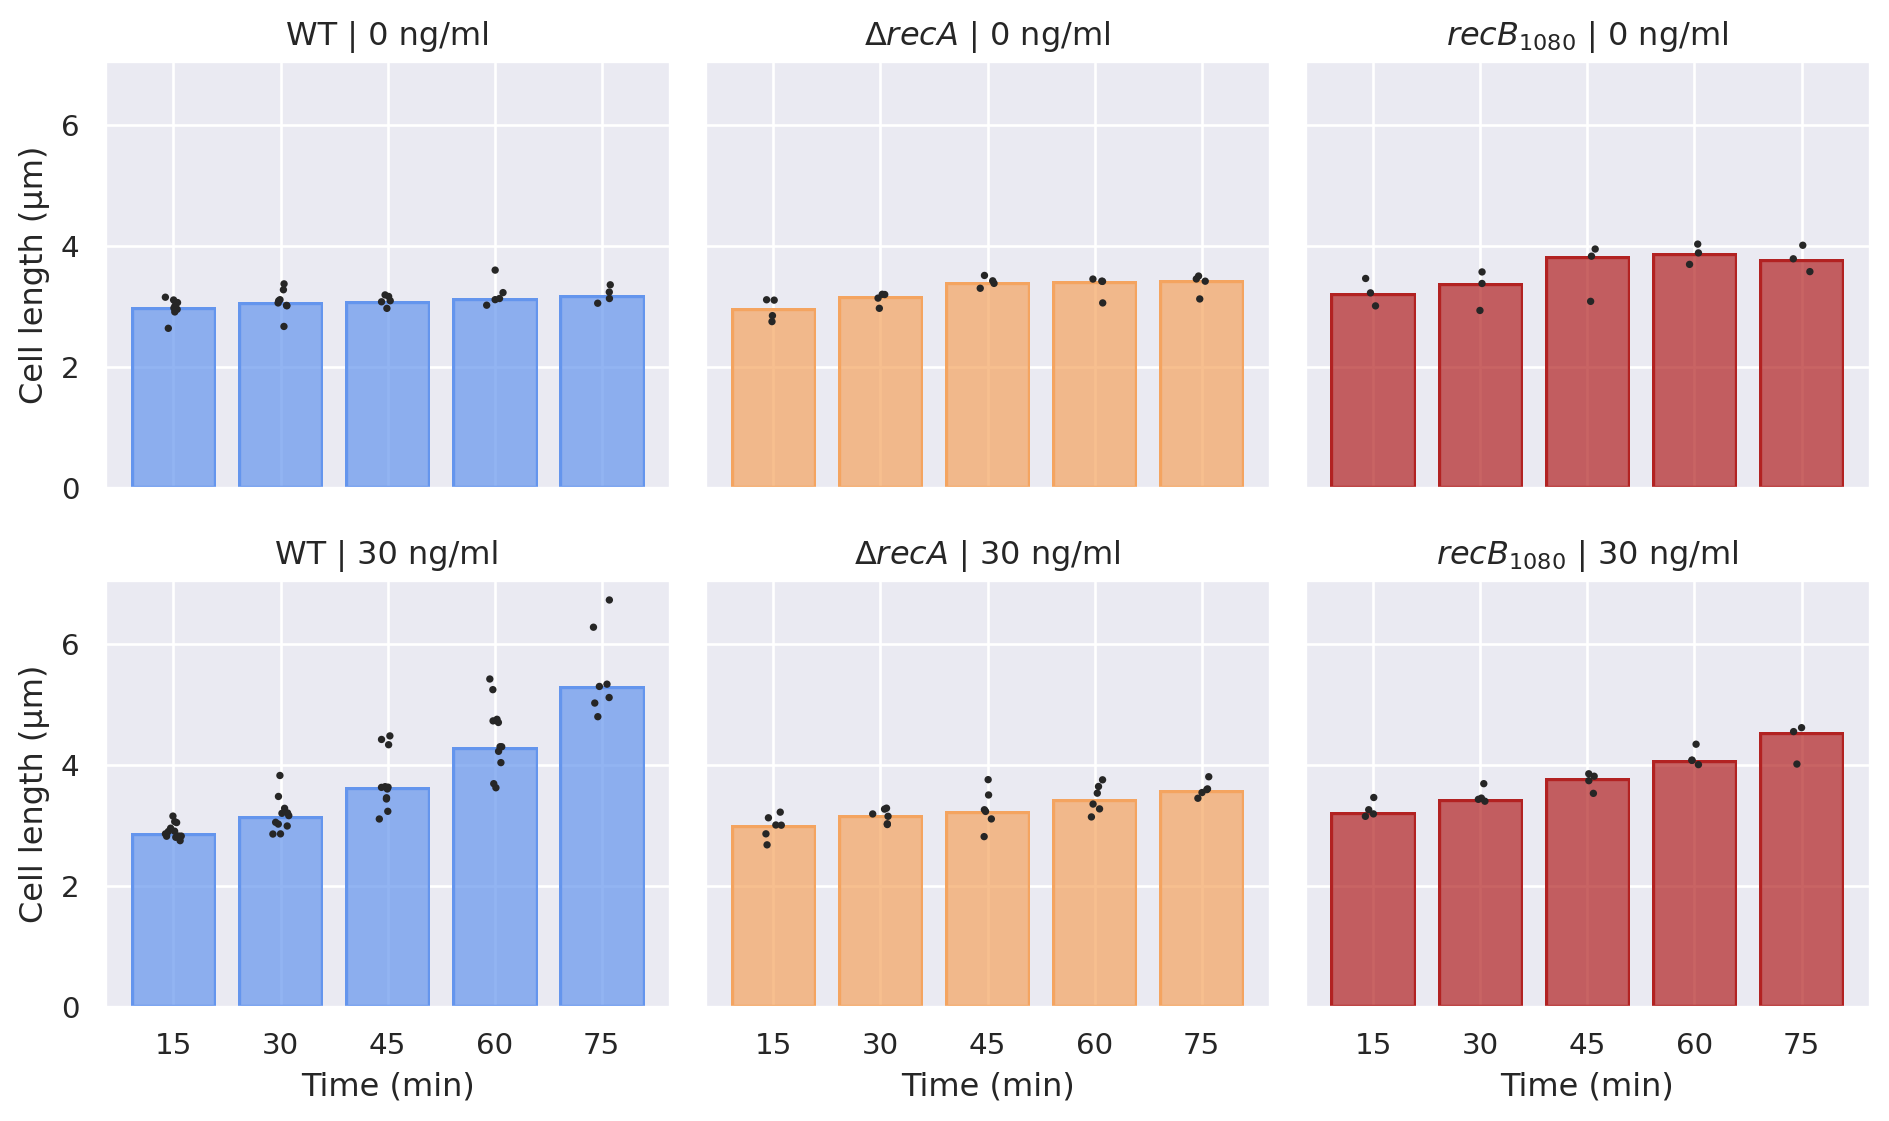

In [70]:
df = (data
      .Bacteria_large
      .groupby(['Group', 'Cipro', 'Strain', 'Dataset', 'Time_min_bin'], observed=True)
      .agg({'SpineLength':'mean'})
      .query('Time_min_bin <= 75')
      )

(
    so.Plot(df, x='Time_min_bin', y='SpineLength', color='Strain')
    .layout(size=(10, 6))
    .facet(row='Cipro', col='Strain')
    .add(so.Bar(), so.Agg('median'), legend=False)
    .add(so.Dots(fillalpha=1, marker='.', color='k'), so.Jitter(), legend=False)
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick'], order=['WT', 'Δ$recA$', '$recB_{1080}$']),
            x=so.Continuous().tick(every=15))
    .label(x='Time (min)', y='Cell length (µm)')
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Mutants_cell_lengths.pdf', format='pdf', bbox_inches='tight')
)

## Bleaching rate fit

In [2]:
from pyberries.data import Fit

bleaching_fit = Fit(data.Bacteria_large, x='Frame', y='SNR', groupby=['Group', 'Strain', 'Cipro', 'Dataset'], model_type='monoexp_decay_offset', p0=[30000, 1, 0])

bleaching_rates = (bleaching_fit.parameters
                   .query('Parameter == "Rate"')
                   .assign(Adjusted_rate=lambda df: df.Value.div(2))  # Adjust rate to frame time
                   )

## RecB spot lifetime fit

### Bi-exponential fit

In [3]:
from pyberries.data import get_model

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Dataset', 'Group', 'Strain', 'Cipro'], density=True, binlabels='left')
lifetime_fit = Fit(hist, x='TrackLength', y='proportion', model_type='biexp_decay', bootstrap_samples=100,
                   groupby=['Dataset', 'Group', 'Strain', 'Cipro'], p0=[1, 1, 0.1, 0.1])

monoexp_decay = get_model('monoexp_decay')

lifetime_fit.data[['Fit_fast', 'Fit_slow']] = pd.DataFrame(columns=['Fit_fast', 'Fit_slow'], dtype='float64')
for ds, df in lifetime_fit.data.groupby('Dataset'):
    params = lifetime_fit.parameters.query('Dataset == @ds')
    df = (df
          .assign(Fit_fast = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_1"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_1"').Value.iloc[0]),
                  Fit_slow = lambda df: monoexp_decay(df.TrackLength,
                                                      Amplitude=params.query('Parameter == "Amplitude_2"').Value.iloc[0],
                                                      Rate=params.query('Parameter == "Rate_2"').Value.iloc[0])
                  )
          )
    lifetime_fit.data.loc[lifetime_fit.data.Dataset == ds,:] = df

/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/daniel/miniconda3/envs/pyberries_dev/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/da

#### Plot fits

##### Supp. Figure 11

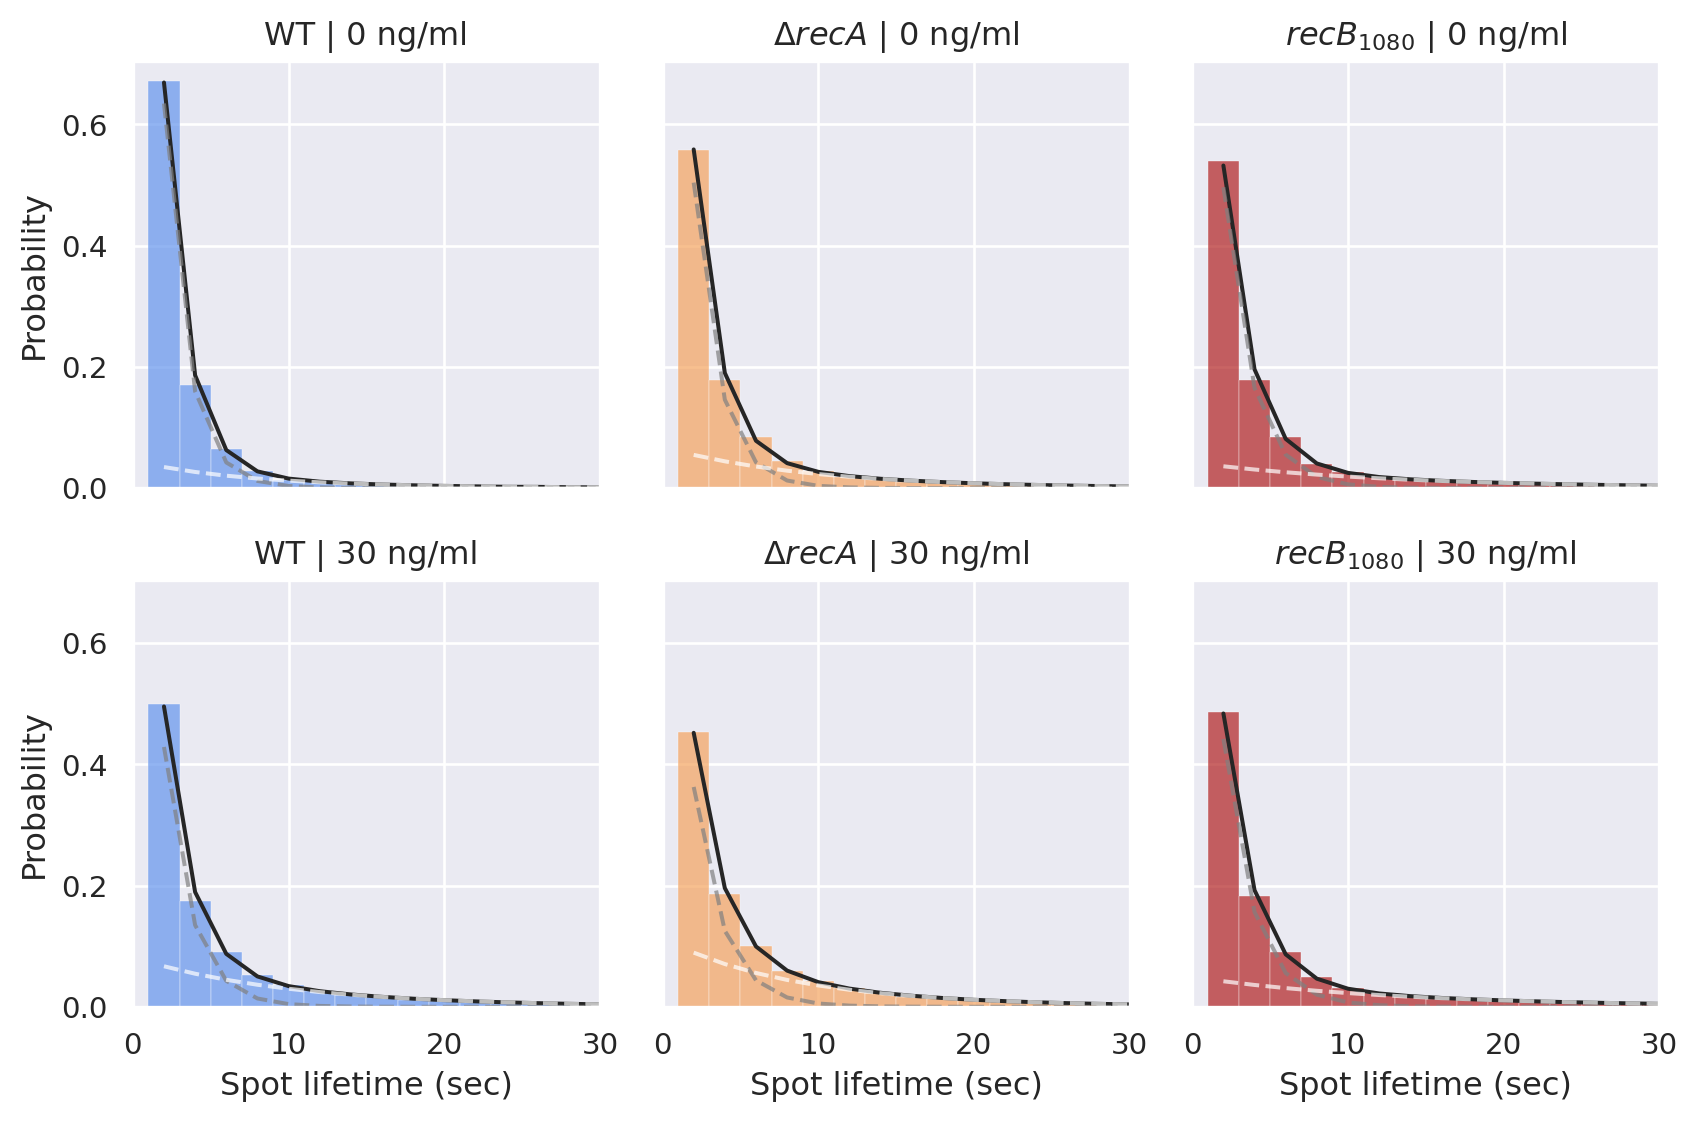

In [73]:
df = (lifetime_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength.mul(2))
      )

(
    so.Plot(df, x='TrackLength_s', color='Strain')
    .layout(size=(9, 6))
    .facet(col='Strain', row='Cipro')
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', legend=False)
    .add(so.Line(linestyle='--', color='gray', alpha=0.7), so.Agg(), y='Fit_fast', legend=False)
    .add(so.Line(linestyle='--', color='white', alpha=0.7), so.Agg(), y='Fit_slow', legend=False)
    .limit(x=(0, 30), y=(None, None))
    .scale(color=so.Nominal(['cornflowerblue', 'sandybrown', 'firebrick']))
    .label(x="Spot lifetime (sec)", y="Probability", color='')
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Python/RecB_article/SI_Figures/Mutants_RecB_fits.pdf', format='pdf', bbox_inches='tight')
)

#### Calculating RecB spot lifetimes from the rates

In [4]:
def split_column(df, col, new, delimiter):
        df[new] = (df[col]
                        .str.split(delimiter, expand=True)
                        )
        return df

lifetimes_biexp = (lifetime_fit
                   .parameters
                   .copy()
                   .pipe(lambda df: split_column(df, col='Parameter', new=['Parameter', 'Rate_type'], delimiter='_'))
                   .replace({'1':'Short', '2':'Long'})
                   .merge(bleaching_rates[['Dataset', 'Value']], on='Dataset', suffixes=(None, '_bleaching'))
                   .pipe(lambda df: pd.pivot_table(df, values=['Value'], index=['Group', 'Strain', 'Cipro', 'Dataset', 'Value_bleaching'], columns=['Parameter', 'Rate_type']))
                   .reset_index()
                   .assign(Lifetime_Short=lambda df: 1/(df.Value.Rate.Short - df.Value_bleaching) *2,
                           Lifetime_Long=lambda df: 1/(df.Value.Rate.Long - df.Value_bleaching) *2,
                           Population_Long=lambda df: df.Value.Amplitude.Long/(df.Value.Amplitude.Short+df.Value.Amplitude.Long) *100,
                           Population_Short=lambda df: 100 - df.Population_Long
                           )
                   .drop(columns=['Value', 'Value_bleaching'], level=0)
                   .droplevel(['Parameter', 'Rate_type'], axis=1)
                   .melt(id_vars=['Group', 'Strain', 'Cipro', 'Dataset'])
                   .pipe(lambda df: split_column(df, col='variable', new=['Parameter', 'Rate_type'], delimiter='_'))
                   .drop(columns='variable')
                   )

#### Make a pretty lifetimes table

##### Table 2

In [88]:
def fuse_cols(df, cols, new, delimiter):
        df[new] = (df[cols]
                   .astype('str')
                   .agg(delimiter.join, axis=1)
                   )
        return df

df = (lifetimes_biexp
      .query('Strain != "WT"')
      .pipe(lambda df: pd.pivot_table(df, values='value', index=['Strain', 'Cipro', 'Dataset', 'Rate_type'], columns='Parameter'))
      .groupby(['Strain', 'Cipro', 'Rate_type'], observed=True)
      .agg(Lifetime_median=('Lifetime', 'median'),
           Lifetime_std=('Lifetime', 'std'),
           Population_median=('Population', 'median'),
           Population_std=('Population', 'std')
           )
      .round(1)
      .pipe(lambda df: fuse_cols(df, cols=['Lifetime_median', 'Lifetime_std'], new='Lifetime (sec)', delimiter=' $\pm$ '))
      .pipe(lambda df: fuse_cols(df, cols=['Population_median', 'Population_std'], new='Population (\%)', delimiter=' $\pm$ '))
      .reset_index()
      .assign(Strain=lambda df: df.Strain
                          .astype('category')
                          .cat.set_categories(['Δ$recA$', '$recB_{1080}$'], ordered=True))
      .sort_values('Strain')
      .set_index(['Strain','Cipro','Rate_type'])
      [['Lifetime (sec)', 'Population (\%)']]
      .rename_axis(['Strain', 'Ciprofloxacin', 'Type'])
      .reindex(['Short', 'Long'], level=2)
      )

display(df)
print(df.to_latex())

Lifetime (sec) Population (\%)
Strain        Ciprofloxacin Type                                 
Δ$recA$       0 ng/ml       Short   1.8 $\pm$ 0.1  96.5 $\pm$ 1.1
                            Long   13.4 $\pm$ 2.4   3.5 $\pm$ 1.1
              30 ng/ml      Short   2.0 $\pm$ 0.2  90.0 $\pm$ 3.3
                            Long   12.2 $\pm$ 3.2  10.0 $\pm$ 3.3
$recB_{1080}$ 0 ng/ml       Short   1.8 $\pm$ 0.1  97.4 $\pm$ 0.9
                            Long   17.3 $\pm$ 4.6   2.6 $\pm$ 0.9
              30 ng/ml      Short   2.1 $\pm$ 0.1  96.5 $\pm$ 0.7
                            Long   19.1 $\pm$ 6.8   3.5 $\pm$ 0.7

\begin{tabular}{lllll}
\toprule
 &  &  & Lifetime (sec) & Population (\%) \\
Strain & Ciprofloxacin & Type &  &  \\
\midrule
\multirow[t]{4}{*}{Δ$recA$} & \multirow[t]{2}{*}{0 ng/ml} & Short & 1.8 $\pm$ 0.1 & 96.5 $\pm$ 1.1 \\
 &  & Long & 13.4 $\pm$ 2.4 & 3.5 $\pm$ 1.1 \\
\cline{2-5}
 & \multirow[t]{2}{*}{30 ng/ml} & Short & 2.0 $\pm$ 0.2 & 90.0 $\pm$ 3.3 \\
 &  & Long & 12.2 $\pm$ 3.2 & 10.0 $\pm$ 3.3 \\
\cline{1-5} \cline{2-5}
\multirow[t]{4}{*}{$recB_{1080}$} & \multirow[t]{2}{*}{0 ng/ml} & Short & 1.8 $\pm$ 0.1 & 97.4 $\pm$ 0.9 \\
 &  & Long & 17.3 $\pm$ 4.6 & 2.6 $\pm$ 0.9 \\
\cline{2-5}
 & \multirow[t]{2}{*}{30 ng/ml} & Short & 2.1 $\pm$ 0.1 & 96.5 $\pm$ 0.7 \\
 &  & Long & 19.1 $\pm$ 6.8 & 3.5 $\pm$ 0.7 \\
\cline{1-5} \cline{2-5}
\bottomrule
\end{tabular}



#### RecB spot lifetimes in mutants - violin plot

                    Group1                  Group2  U_statistic   p_value
0    $recB_{1080}$ 0 ng/ml  $recB_{1080}$ 30 ng/ml          2.0  0.228571
1    $recB_{1080}$ 0 ng/ml              WT 0 ng/ml         18.0  0.278788
2    $recB_{1080}$ 0 ng/ml             WT 30 ng/ml         30.0  0.101099
3    $recB_{1080}$ 0 ng/ml         Δ$recA$ 0 ng/ml         11.0  0.114286
4    $recB_{1080}$ 0 ng/ml        Δ$recA$ 30 ng/ml         16.0  0.095238
5   $recB_{1080}$ 30 ng/ml              WT 0 ng/ml         26.0  0.109091
6   $recB_{1080}$ 30 ng/ml             WT 30 ng/ml         46.0  0.004396
7   $recB_{1080}$ 30 ng/ml         Δ$recA$ 0 ng/ml         16.0  0.028571
8   $recB_{1080}$ 30 ng/ml        Δ$recA$ 30 ng/ml         24.0  0.009524
9               WT 0 ng/ml             WT 30 ng/ml         31.0  0.208288
10              WT 0 ng/ml         Δ$recA$ 0 ng/ml         10.0  0.367677
11              WT 0 ng/ml        Δ$recA$ 30 ng/ml         18.0  0.490842
12             WT 30 ng/ml         Δ$r

/tmp/ipykernel_10185/3863538193.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set(xlabel='', ylabel='RecB spot lifetime (sec)', ylim=(None, 50), xticklabels=['WT', 'Δ$recA$', '$recB_{1080}$'])


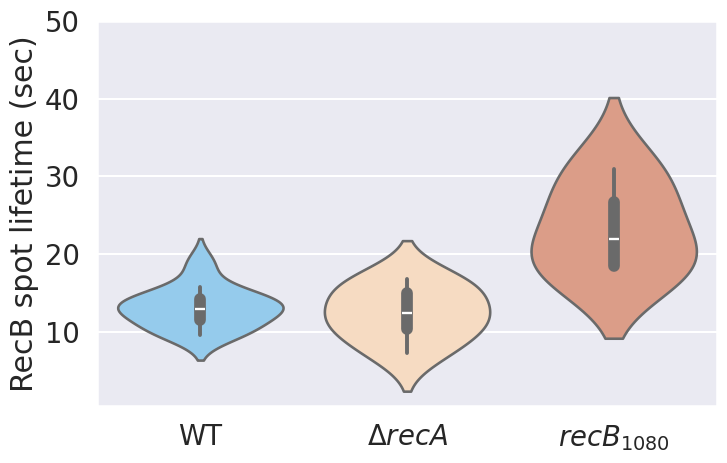

In [6]:
from pyberries.stats import mann_whitney_test
import seaborn as sns
import matplotlib.pyplot as plt

df = (lifetimes_biexp
      .pipe(lambda df: pd.pivot_table(df, values='value', index=['Group', 'Strain', 'Cipro', 'Dataset', 'Rate_type'], columns='Parameter'))
      .query('Rate_type == "Long"')
      .reset_index()
      .query('Cipro != "0"')
      )

res = mann_whitney_test(data=df, col='Lifetime', by=['Strain', 'Cipro'])
print(res)

fig, ax = plt.subplots(figsize=(8, 5))
sns.set_theme(style='darkgrid')
sns.set_context(context='talk', font_scale=1.2)
g = sns.violinplot(data=df, x='Group', y='Lifetime', hue='Group', palette=['lightskyblue', 'peachpuff', 'darksalmon'], order=['WT, 30 ng/ml', 'Δ$recA$, 30 ng/ml', '$recB_{1080}$, 30 ng/ml'], hue_order=['WT, 30 ng/ml', 'Δ$recA$, 30 ng/ml', '$recB_{1080}$, 30 ng/ml'], alpha=1, ax=ax, legend=False)
g.set(xlabel='', ylabel='RecB spot lifetime (sec)', ylim=(None, 50), xticklabels=['WT', 'Δ$recA$', '$recB_{1080}$'])
g.get_figure().savefig('/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2025-05-03_Figures/RecB_Lifetimes.svg', format='svg', bbox_inches='tight')

## Estimate the rate of RecB recruitment to DNA

### Figure 3B

recruitment_rate     
                                mean  std
Strain        Cipro                      
WT            0                  1.6  1.1
              30                10.8  4.3
Δ$recA$       0                  8.3  2.8
              30                28.8  9.5
$recB_{1080}$ 0                  8.5  1.7
              30                14.9  3.4

              Group1            Group2  U_statistic   p_value
0    $recB_{1080}$ 0  $recB_{1080}$ 30          0.0  0.057143
1    $recB_{1080}$ 0              WT 0         24.0  0.012121
2    $recB_{1080}$ 0             WT 30         12.0  0.448352
3    $recB_{1080}$ 0         Δ$recA$ 0          7.0  0.857143
4    $recB_{1080}$ 0        Δ$recA$ 30          0.0  0.023810
5   $recB_{1080}$ 30              WT 0         32.0  0.004040
6   $recB_{1080}$ 30             WT 30         38.0  0.103297
7   $recB_{1080}$ 30         Δ$recA$ 0         16.0  0.028571
8   $recB_{1080}$ 30        Δ$recA$ 30          2.0  0.038095
9               WT 0             WT 30          0.0  0.000016
10              WT 0         Δ$recA$ 0          0.0  0.004040
11              WT 0        Δ$recA$ 30          0.0  0.000666
12             WT 30         Δ$recA$ 0         34.0  0.261538
13             WT 30        Δ$recA$ 30          2.0  0.000431
14         Δ$recA$ 0        Δ$recA$ 30          0.0  0.009524


/tmp/ipykernel_10185/3403261193.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set(xlabel='', ylabel='RecB recruitment per cell (h$^{-1}$)', ylim=(None, 70), xticklabels=['WT', 'Δ$recA$', '$recB_{1080}$', 'WT', 'Δ$recA$', '$recB_{1080}$'])


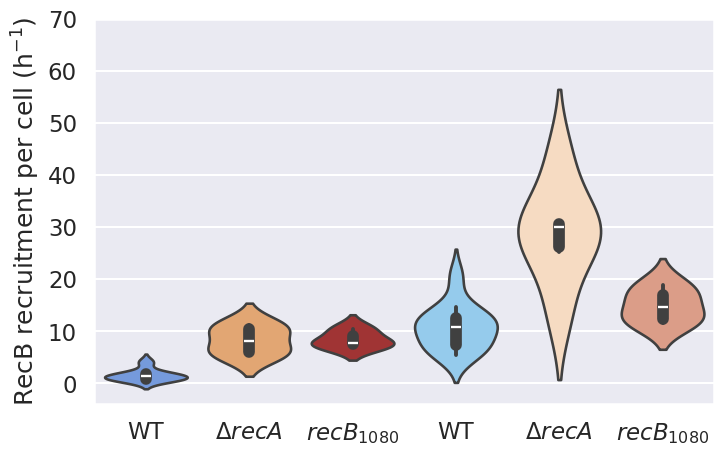

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyberries.stats import mann_whitney_test

df = (data
      .RecB_spots
      .query('Time_min_bin < 90 and Frame > 0')
      .groupby(by=['Group', 'Dataset', 'ParentIndices'])
      .agg({'Indices': 'count'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .groupby(by=['Group', 'Dataset'])
      .agg({'SpotCount': 'sum'})
      .reset_index()
      .merge(data
             .Bacteria_large
             .groupby(['Dataset'])
             .agg({'Position':'count'})
             .reset_index()
             .rename(columns={'Position':'nCells'}),
             how='left',
             on=['Dataset'],
             suffixes=('_old', None)
             )
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.SpotCount / df.nCells
              )
      .merge(lifetimes_biexp
             .query('Parameter == "Population" and Rate_type == "Long"')
             .rename(columns={'value':'long_lived'})
             .assign(long_lived=lambda df: (df.long_lived)/100),  # Subtract long-lived population in Gam data
             on=['Group', 'Dataset']
             )
       .merge(bleaching_fit.data  # Retrieve the average "labelling efficiency" over the timelapse
              .groupby('Dataset')
              .agg(efficiency=('Fit', lambda x: x.mean()/x.iloc[0])),
              on='Dataset'
              )
      .assign(recruitment_rate=lambda df: df.norm_count /98*60*60 *df.long_lived / df.efficiency,  # Rate of DSB formation (h-1)
              Cipro=lambda df: df.Cipro.str.replace(' ng/ml',''))
#       .query('Strain != "WT"')
      )

display(df
        .assign(Strain=lambda df: df.Strain
                                   .astype('category')
                                   .cat.set_categories(['WT', 'Δ$recA$', '$recB_{1080}$'], ordered=True))
        .sort_values('Strain')
        .groupby(['Strain', 'Cipro'], observed=True)
        .agg({'recruitment_rate':['mean', 'std']})
        .round(1)
        )

res = mann_whitney_test(data=df, col='recruitment_rate', by=['Strain', 'Cipro'])
print(res)

fig, ax = plt.subplots(figsize=(8, 5))
sns.set_theme(style='darkgrid')
sns.set_context(context='talk', font_scale=1)
g = sns.violinplot(data=df, x='Group', y='recruitment_rate', hue='Group', palette=['cornflowerblue', 'sandybrown', 'firebrick', 'lightskyblue', 'peachpuff', 'darksalmon'], alpha=1, order=['WT, 0 ng/ml', 'Δ$recA$, 0 ng/ml', '$recB_{1080}$, 0 ng/ml', 'WT, 30 ng/ml', 'Δ$recA$, 30 ng/ml', '$recB_{1080}$, 30 ng/ml'], hue_order=['WT, 0 ng/ml', 'Δ$recA$, 0 ng/ml', '$recB_{1080}$, 0 ng/ml', 'WT, 30 ng/ml', 'Δ$recA$, 30 ng/ml', '$recB_{1080}$, 30 ng/ml'], legend=False, ax=ax)
g.set(xlabel='', ylabel='RecB recruitment per cell (h$^{-1}$)', ylim=(None, 70), xticklabels=['WT', 'Δ$recA$', '$recB_{1080}$', 'WT', 'Δ$recA$', '$recB_{1080}$'])
g.get_figure().savefig('/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2025-05-03_Figures/Recruitment_rate_mutants_2.svg', format='svg', bbox_inches='tight') 